In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
import time

# Load training data

In [2]:
clf_dict = pickle.load(open("rbf_hog_YUV_hist_prob.p", 'rb'))
clf = clf_dict["clf"]
X_scaler = clf_dict["X_scaler"]
orientations = clf_dict["orientations"]
pix_per_cell = clf_dict["pix_per_cell"]
cell_per_block = clf_dict["cell_per_block"]
spatial_size = clf_dict["spatial_size"]
hist_bins = clf_dict["hist_bins"]
color_space = clf_dict["color_space"]
hog_channel = clf_dict["hog_channel"]

In [3]:
from car_finder import *
from lane_finder import *

In [4]:
vehicle_tracker = VehicleTracker(clf=clf, scaler=X_scaler, 
                                 color_space=color_space, orientations=orientations, 
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                 hist_bins=hist_bins)


0.17 s Finding windows...


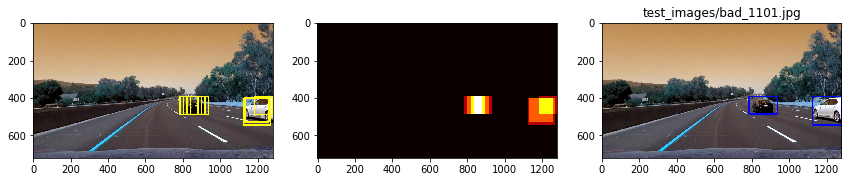

0.18 s Finding windows...


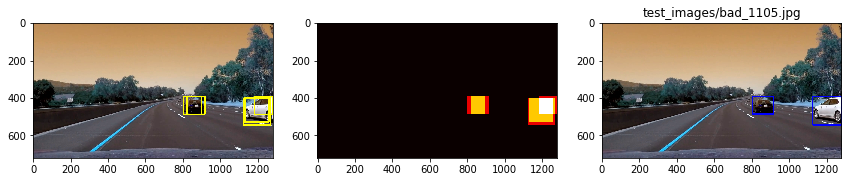

0.17 s Finding windows...


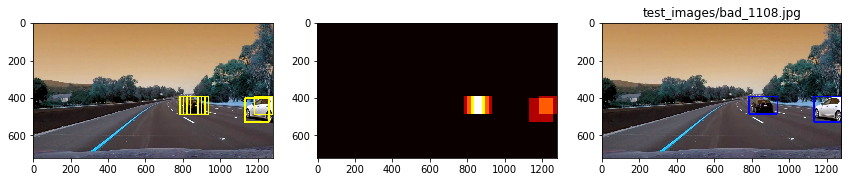

0.21 s Finding windows...


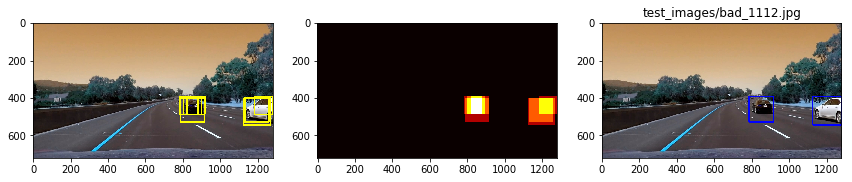

0.21 s Finding windows...


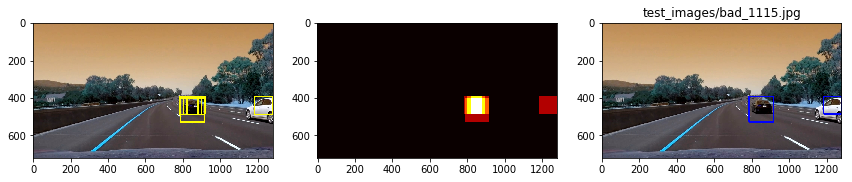

0.21 s Finding windows...


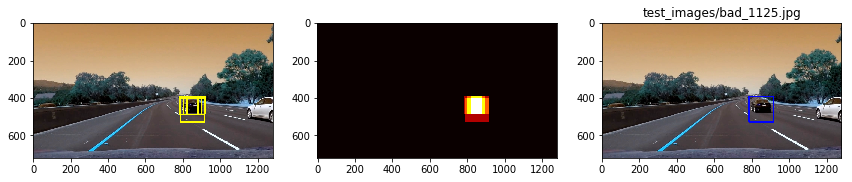

0.19 s Finding windows...


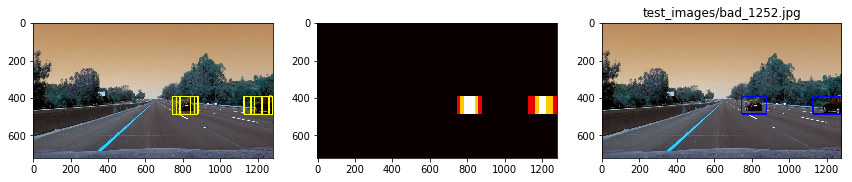

0.18 s Finding windows...


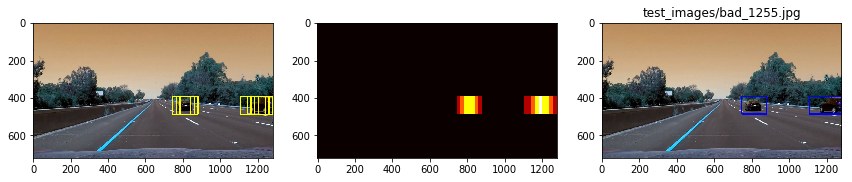

0.18 s Finding windows...


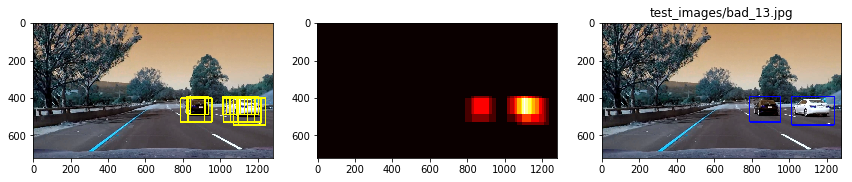

0.18 s Finding windows...


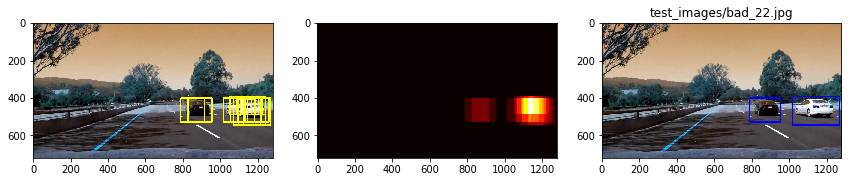

0.18 s Finding windows...


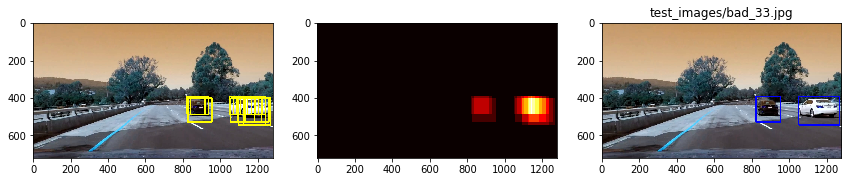

0.18 s Finding windows...


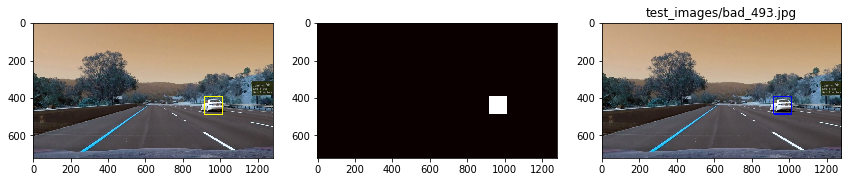

0.19 s Finding windows...


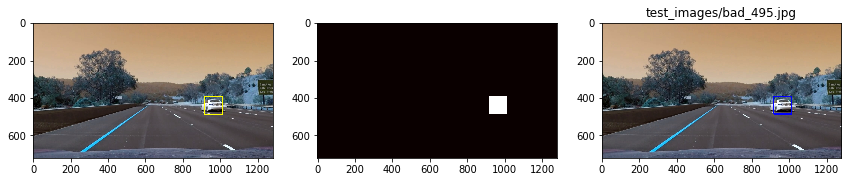

0.18 s Finding windows...


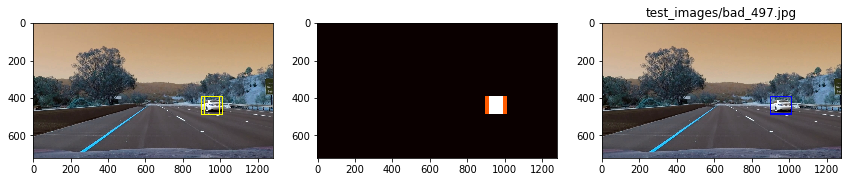

0.19 s Finding windows...


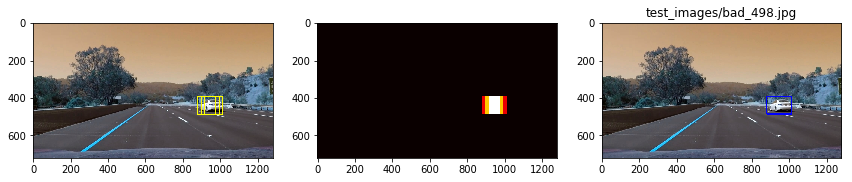

0.2 s Finding windows...


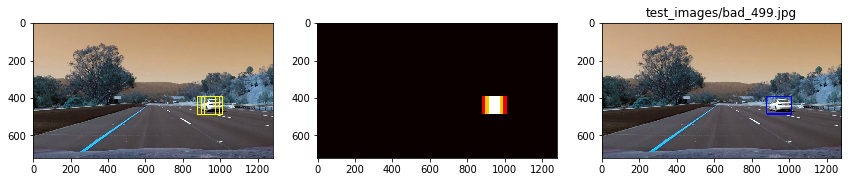

0.19 s Finding windows...


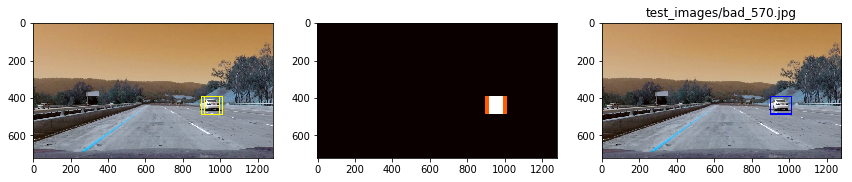

0.17 s Finding windows...


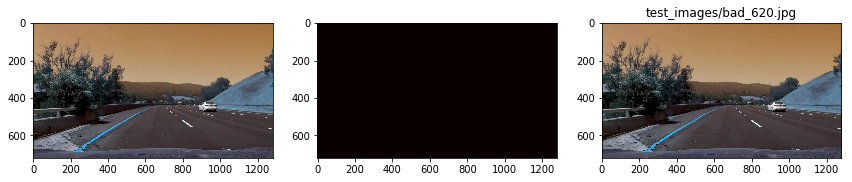

0.17 s Finding windows...


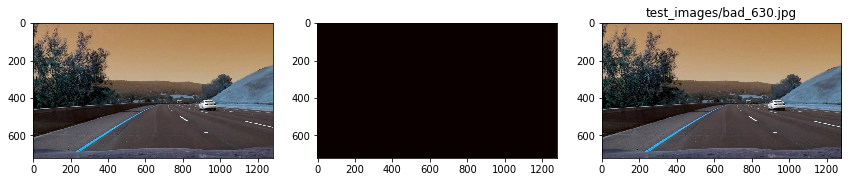

0.17 s Finding windows...


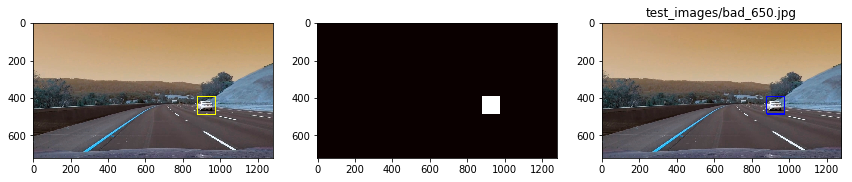

0.17 s Finding windows...


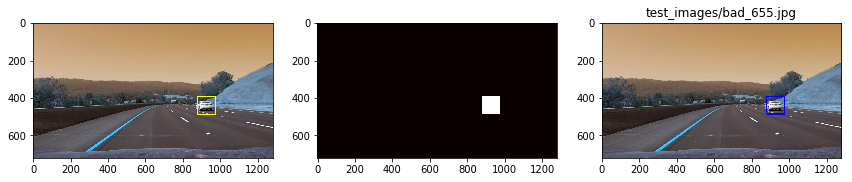

0.18 s Finding windows...


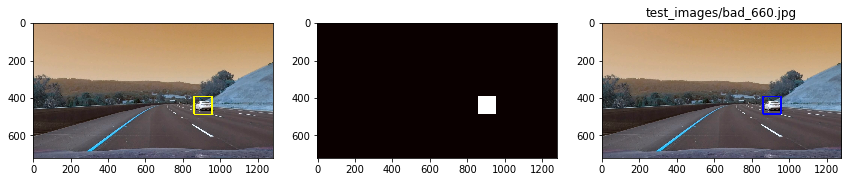

0.17 s Finding windows...


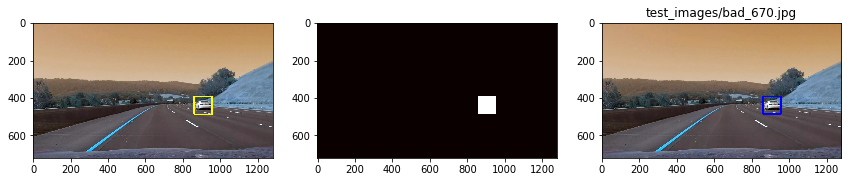

0.18 s Finding windows...


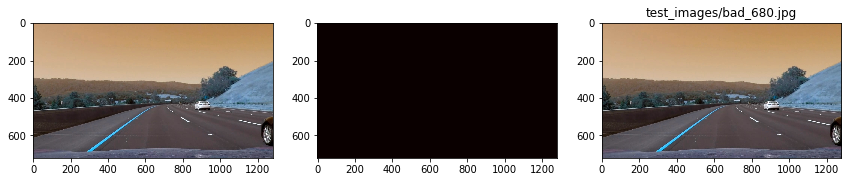

0.19 s Finding windows...


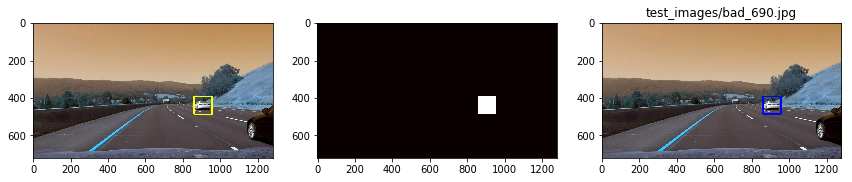

0.18 s Finding windows...


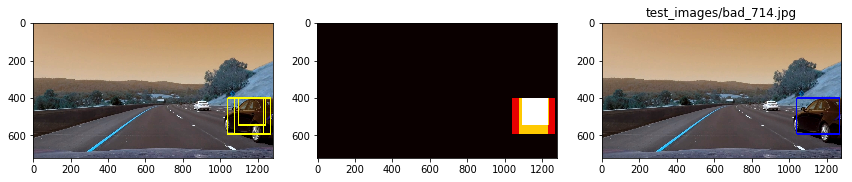

0.19 s Finding windows...


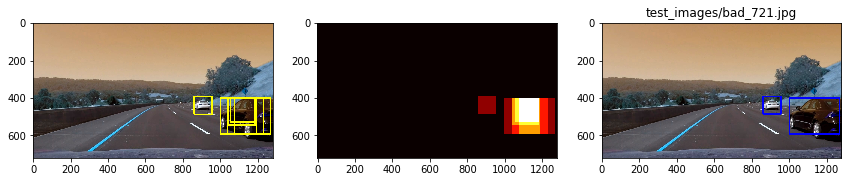

0.18 s Finding windows...


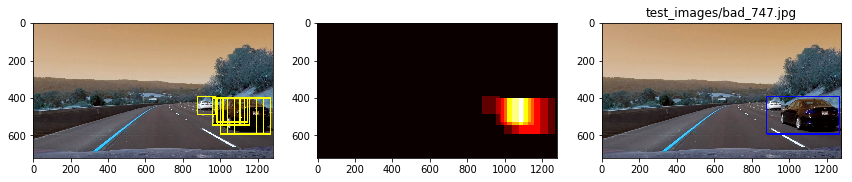

0.19 s Finding windows...


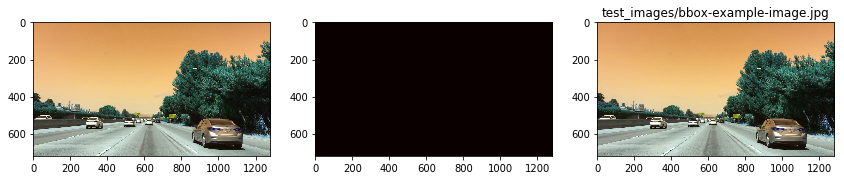

0.18 s Finding windows...


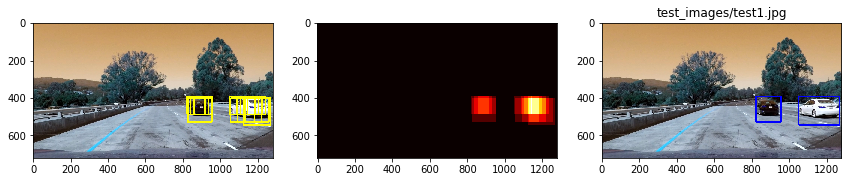

0.19 s Finding windows...


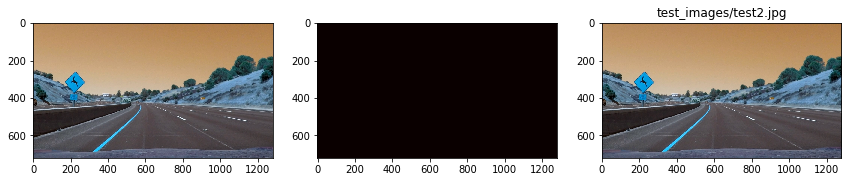

0.19 s Finding windows...


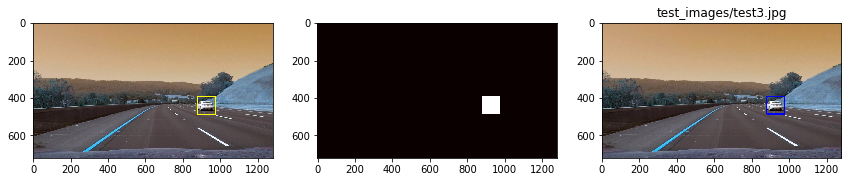

0.18 s Finding windows...


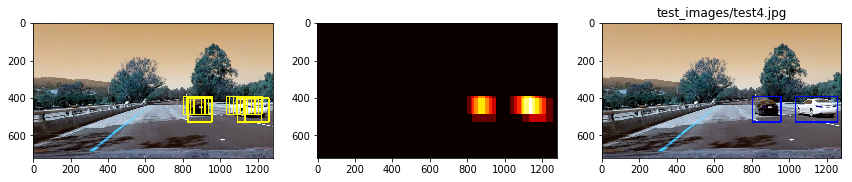

0.19 s Finding windows...


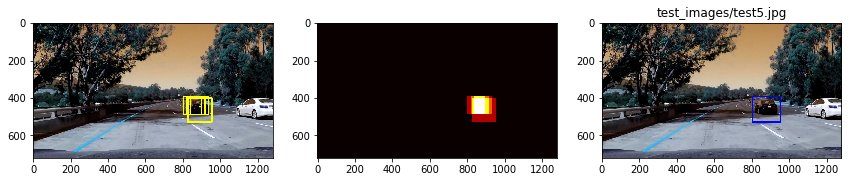

0.2 s Finding windows...


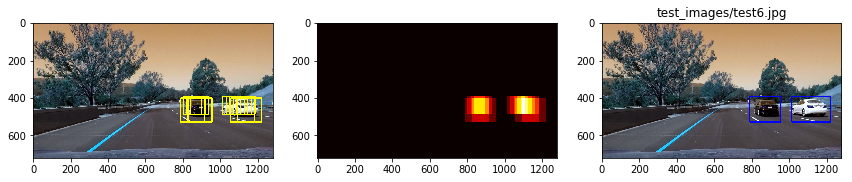

In [5]:
for img_path in glob.glob('test_images/*.jpg'):
    f, plots = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
    
    img = cv2.imread(img_path)
    plt.title(img_path)
    t = time.time()
    boxes = vehicle_tracker.find_cars_windows(img)
    
    print(round(time.time()-t, 2), 's Finding windows...')
    
    draw_image = np.copy(img)
    draw_image = draw_boxes(draw_image, boxes, color=(255, 255, 0), thick=6)
    plots[0].imshow(draw_image)

    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0.25)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    plots[1].imshow(heatmap, cmap='hot')
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    bboxes = get_bboxes(labels)
    for box in bboxes:
        width = (box[1][0] - box[0][0])
        height = (box[1][1] - box[0][1])
        color = (0, 0, 255)
        if (width/height < 0.6 or width/height > 2.0):
            color = (255, 0, 0)
        cv2.rectangle(img, box[0], box[1], color, 6)
    plots[2].imshow(img)
    f.tight_layout()
    plt.show()

In [6]:
calibration = pickle.load(open("cam_calibration.p", "rb"))
class Pipeline():
    def __init__(self):
        self.vehicle_tracker = VehicleTracker(clf=clf, scaler=X_scaler, 
                                 color_space=color_space, orientations=orientations, 
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                 hist_bins=hist_bins)
        self.lane_finder = LaneFinder(calibration['mtx'], calibration['dist'])
        
    def process(self, img):
        draw_img= np.copy(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        self.lane_finder.process(img)
        draw_img = self.lane_finder.draw(draw_img)
        
        self.vehicle_tracker.process(img)
        draw_img = self.vehicle_tracker.draw(draw_img)
        
        return draw_img

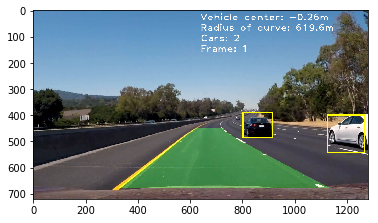

In [7]:
test_img = cv2.imread('test_images/bad_1105.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
pipeline = Pipeline()
result = pipeline.process(test_img)
plt.imshow(result)
plt.show()

# Video

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_video(name):
    video_output_path = 'output_images/'+name+'_combined_fast.mp4'
    input_clip = VideoFileClip(name + '.mp4')
#     input_clip = input_clip.subclip(28,47)
    pipeline = Pipeline()
    output_clip = input_clip.fl_image(pipeline.process) #NOTE: this function expects color images!!
    %time output_clip.write_videofile(video_output_path, audio=False)


process_video('project_video')

[MoviePy] >>>> Building video output_images/project_video_combined_fast_1.mp4
[MoviePy] Writing video output_images/project_video_combined_fast_1.mp4


100%|█████████▉| 1260/1261 [08:50<00:00,  1.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_combined_fast_1.mp4 

CPU times: user 9min 20s, sys: 1min 30s, total: 10min 50s
Wall time: 8min 51s
